# Installing necessary packages

In [22]:
!pip install zipline-reloaded
%load_ext autoreload
%autoreload 2
import calendar
import os
import pandas as pd
from datetime import datetime, timezone
import zipline
from zipline.data import bundles as bundles_module
from zipline.data.bundles import register, unregister
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
from zipline.api import (order, 
                         record, 
                         symbol,
                         set_commission,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_slippage,
                         schedule_function, date_rules, time_rules,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.api import order_target, record, symbol
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from zipline.finance.commission import PerDollar
import matplotlib.pyplot as plt
from utils import *
import stats
from os import listdir
import pytz
import talib as ta

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading & ingesting dataset

In [23]:
%%capture warnings
calendar_name = 'NYSE'
register("stockdata", csvdir_equities(["daily"],'train/'),calendar_name=calendar_name)
bundles_module.ingest("stockdata")

 | ACG: sid 0
 | BTL: sid 1
 | CFL: sid 2
 | DFT: sid 3
 | FE: sid 4
 | JZIL: sid 5
 | KWF: sid 6
 | LS: sid 7
 | MUN: sid 8
 | NAB: sid 9
 | NIH: sid 10
 | VME: sid 11


# Showing dataset

In [24]:
names = "DFT, ACG, LS, CFL, NAB, BTL, KWF, FE, JZIL, MUN, NIH, VME"
stocks = [x for x in names.split(", ")]
bundle = 'stockdata'
start="2003-07-03"
end = "2004-07-06"
db_obj = dailyBars(coins=stocks, bundle=bundle, calendar=get_calendar("NYSE"))
db_obj.ohlcvData(start, end, value_list=['volume'])

volume                                          \
                                DFT        ACG       LS       CFL       NAB   
2003-07-03 00:00:00+00:00  221162.0   928544.0  43426.0   89672.0   33070.0   
2003-07-07 00:00:00+00:00  220322.0  1003076.0  45070.0   62946.0   38258.0   
2003-07-08 00:00:00+00:00  197148.0   825230.0  39548.0   62446.0   32068.0   
2003-07-09 00:00:00+00:00  211242.0   878924.0  42980.0   88506.0   39148.0   
2003-07-10 00:00:00+00:00  179942.0   873792.0  26716.0   71244.0   32062.0   
...                             ...        ...      ...       ...       ...   
2004-06-29 00:00:00+00:00  142422.0   751966.0  57256.0   58200.0   65318.0   
2004-06-30 00:00:00+00:00  272960.0  1212152.0  80912.0  144592.0   97190.0   
2004-07-01 00:00:00+00:00  313290.0  1538268.0  73320.0  116760.0  102134.0   
2004-07-02 00:00:00+00:00  220510.0  1149846.0  70732.0   74790.0   73386.0   
2004-07-06 00:00:00+00:00  317106.0  1924154.0  87770.0  177114.0   86658.0   

                                                                             \
                                BTL       KWF        FE      JZIL       MUN   
2003-07-03 00:00:00+00:00  118414.0   79406.0   95095.0   83900.0   37088.0   
2003-07-07 00:00:00+00:00   79502.0  108452.0   91637.0   71882.0   28446.0   
2003-07-08 00:00:00+00:00   66798.0  693532.0   84472.0   62504.0   27962.0   
2003-07-09 00:00:00+00:00  128542.0  493700.0  147170.0   96260.0   29256.0   
2003-07-10 00:00:00+00:00   77730.0  539970.0  105038.0   68702.0   29886.0   
...                             ...       ...       ...       ...       ...   
2004-06-29 00:00:00+00:00  105804.0  204926.0  113286.0   65144.0   38176.0   
2004-06-30 00:00:00+00:00  125388.0  164708.0  431185.0   86440.0   70648.0   
2004-07-01 00:00:00+00:00  160260.0  248354.0  219804.0  110602.0   72272.0   
2004-07-02 00:00:00+00:00  129518.0  413112.0  160741.0  119372.0   53552.0   
2004-07-06 00:00:00+00:00  178978.0  185132.0  175608.0  109650.0  116248.0   

                                             
                               NIH      VME  
2003-07-03 00:00:00+00:00  13006.0  18776.0  
2003-07-07 00:00:00+00:00   9076.0  15350.0  
2003-07-08 00:00:00+00:00   8296.0  16174.0  
2003-07-09 00:00:00+00:00   9496.0  11828.0  
2003-07-10 00:00:00+00:00   7874.0  15446.0  
...                            ...      ...  
2004-06-29 00:00:00+00:00  18712.0  15914.0  
2004-06-30 00:00:00+00:00  53336.0  30334.0  
2004-07-01 00:00:00+00:00  32746.0  22996.0  
2004-07-02 00:00:00+00:00  33864.0  18190.0  
2004-07-06 00:00:00+00:00  30570.0  26942.0  

[253 rows x 12 columns]

# Defining Model Parameters

In [14]:
intial_portfolio = 500000
upper = 70
lower = 30
rsi_period = 4
vola_window = 10
mportfolio_size = 15
start = datetime(2003, 7, 3, 0, 0, 0, 0, pytz.UTC)
end = datetime(2004, 7, 6, 0, 0, 0, 0, pytz.UTC)
TICKERS = [f[:-4] for f in listdir('train/daily/')][1:-1]
# Commission and Slippage Parameters
enable_commission = True
commission_pct = 0.004
enable_slippage = True 
slippage_volume_limit = 0.025
slippage_impact = 0.05
calendar = get_calendar('NYSE')

# Custom Functions

In [27]:
def compute_rsi(close):
    rsi = ta.RSI(close.values, timeperiod=rsi_period)
    return rsi[-1]
def volatility(ts):
    std = ts.pct_change().dropna().rolling(vola_window).std().mean() #iloc[-1]
    return std
def output_progress(context):
    today = zipline.api.get_datetime().date()
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    print("{} - Last Month Result: {:.2%}".format(today, perf_pct))
    context.last_month = context.portfolio.portfolio_value
def analyze(context, perf):
    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()
    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1
    print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))
    return  


# Initialization the trading logic

In [34]:
def initialize(context):
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)
    if enable_slippage:
        slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)
    else:
        slippage_model=FixedSlippage(spread=0.0)   
    set_slippage(slippage_model)    
    context.last_month = intial_portfolio
    context.index_members = TICKERS
    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )



In [35]:
def rebalance(context, data):
    output_progress(context)
    universe = [symbol(ticker) for ticker in context.index_members]
    hist = data.history(universe, "close", 20, "1d")
    hist = hist.dropna()
    ranking_table = hist.apply(compute_rsi).sort_values(ascending=True)  
    kept_positions = list(context.portfolio.positions.keys())
    for security in context.portfolio.positions:
        if (security not in universe):
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
        elif ranking_table[security] > upper:
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
    
    replacement_stocks = mportfolio_size - len(kept_positions)
    buy_list = ranking_table.loc[~ranking_table.index.isin(kept_positions)]
    buy_list = buy_list[buy_list.loc[buy_list.index] < lower].dropna()[:replacement_stocks]    
    new_portfolio = pd.concat((buy_list,ranking_table.loc[ranking_table.index.isin(kept_positions)]))
    

    vola_table = hist[new_portfolio.index].apply(volatility)
    inv_vola_table = 1 / vola_table 
    sum_inv_vola = np.sum(inv_vola_table)         
    vola_target_weights = inv_vola_table / sum_inv_vola
    
    for security, rank in new_portfolio.iteritems():
        weight = vola_target_weights[security]
        if security in kept_positions:
            order_target_percent(security, weight)
        else:
            if ranking_table[security] < lower:
                order_target_percent(security, weight)


In [36]:
perf = run_algorithm(
    start = pd.Timestamp('2003-07-03',tz ='utc'),
    end = pd.Timestamp('2004-07-06',tz ='utc'),
    initialize=initialize, 
    capital_base=intial_portfolio,  
    analyze=analyze, 
    data_frequency = 'daily', 
    bundle= 'stockdata')

2003-08-01 - Last Month Result: 0.00%
2003-09-02 - Last Month Result: 0.00%
2003-10-01 - Last Month Result: -3.01%
2003-11-03 - Last Month Result: -0.64%
2003-12-01 - Last Month Result: -2.35%
2004-01-02 - Last Month Result: 4.79%
2004-02-02 - Last Month Result: -0.06%
2004-03-01 - Last Month Result: 2.08%
2004-04-01 - Last Month Result: 8.50%
2004-05-03 - Last Month Result: -7.43%
2004-06-01 - Last Month Result: 8.84%
2004-07-01 - Last Month Result: 4.05%
Annualized Return: 10.89% Max Drawdown: -15.05%


In [37]:
perf

,period_open,period_close,portfolio_value,longs_count,shorts_count,long_value,short_value,long_exposure,pnl,capital_used,...,sharpe,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,period_label,max,dd
2003-07-03 17:00:00+00:00,2003-07-03 13:31:00+00:00,2003-07-03 17:00:00+00:00,500000.000000,0,0,0.000,0.0,0.000,0.000000,0.000000,...,NaN,NaN,0.000000,0.00000,0.0,0.0,1,2003-07,500000.000000,0.000000
2003-07-07 20:00:00+00:00,2003-07-07 13:31:00+00:00,2003-07-07 20:00:00+00:00,500000.000000,0,0,0.000,0.0,0.000,0.000000,0.000000,...,NaN,NaN,0.000000,0.00000,0.0,0.0,2,2003-07,500000.000000,0.000000
2003-07-08 20:00:00+00:00,2003-07-08 13:31:00+00:00,2003-07-08 20:00:00+00:00,500000.000000,0,0,0.000,0.0,0.000,0.000000,0.000000,...,NaN,NaN,0.000000,0.00000,0.0,0.0,3,2003-07,500000.000000,0.000000
2003-07-09 20:00:00+00:00,2003-07-09 13:31:00+00:00,2003-07-09 20:00:00+00:00,500000.000000,0,0,0.000,0.0,0.000,0.000000,0.000000,...,NaN,NaN,0.000000,0.00000,0.0,0.0,4,2003-07,500000.000000,0.000000
2003-07-10 20:00:00+00:00,2003-07-10 13:31:00+00:00,2003-07-10 20:00:00+00:00,500000.000000,0,0,0.000,0.0,0.000,0.000000,0.000000,...,NaN,NaN,0.000000,0.00000,0.0,0.0,5,2003-07,500000.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-06-29 20:00:00+00:00,2004-06-29 13:31:00+00:00,2004-06-29 20:00:00+00:00,586595.829334,4,0,771400.013,0.0,771400.013,2198.171358,-3327.928642,...,0.939423,1.387171,-0.150454,1.75603,0.0,0.0,249,2004-06,598297.170458,-0.019558
2004-06-30 20:00:00+00:00,2004-06-30 13:31:00+00:00,2004-06-30 20:00:00+00:00,583583.511905,4,0,771619.168,0.0,771619.168,-3012.317428,-3231.472428,...,0.910048,1.343353,-0.150454,1.75603,0.0,0.0,250,2004-06,598297.170458,-0.024593
2004-07-01 20:00:00+00:00,2004-07-01 13:31:00+00:00,2004-07-01 20:00:00+00:00,572115.855347,4,0,757921.925,0.0,757921.925,-11467.656558,2229.586442,...,0.800351,1.174597,-0.150454,1.75603,0.0,0.0,251,2004-07,598297.170458,-0.043760
2004-07-02 20:00:00+00:00,2004-07-02 13:31:00+00:00,2004-07-02 20:00:00+00:00,580643.281617,8,0,816958.347,0.0,816958.347,8527.426270,-50508.995730,...,0.874127,1.286425,-0.150454,1.75603,0.0,0.0,252,2004-07,598297.170458,-0.029507


Starting portfolio value: 500000.0
Final portfolio value: 554702.2765765167
Average sharpe: 0.812723953451519
Max drawdown: -0.15045414461068007


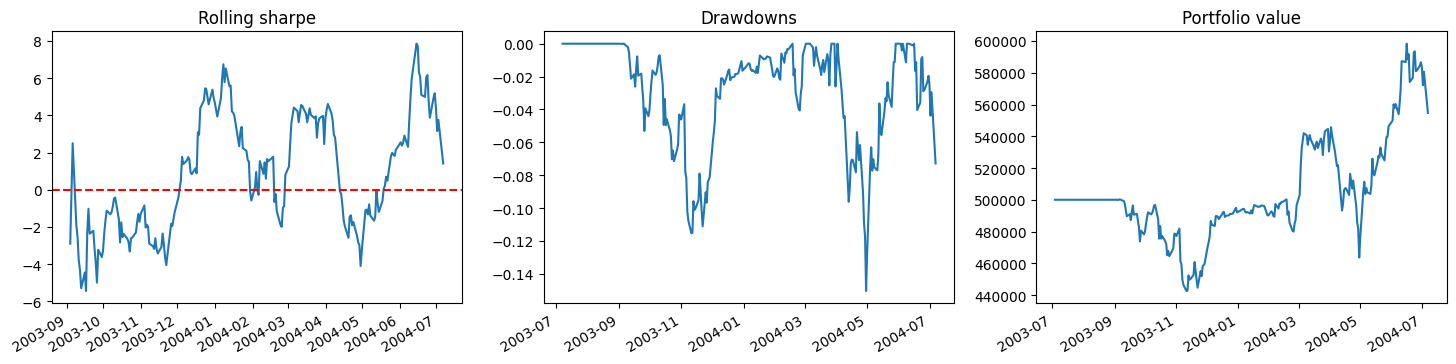

,period_open,period_close,portfolio_value,longs_count,shorts_count,long_value,short_value,long_exposure,pnl,capital_used,...,max_leverage,excess_return,treasury_period_return,trading_days,period_label,max,dd,rolling_sharpe,rolling_vol,drawdowns
2003-07-03 17:00:00+00:00,2003-07-03 13:31:00+00:00,2003-07-03 17:00:00+00:00,500000.000000,0,0,0.000,0.0,0.000,0.000000,0.000000,...,0.00000,0.0,0.0,1,2003-07,500000.000000,0.000000,NaN,NaN,NaN
2003-07-07 20:00:00+00:00,2003-07-07 13:31:00+00:00,2003-07-07 20:00:00+00:00,500000.000000,0,0,0.000,0.0,0.000,0.000000,0.000000,...,0.00000,0.0,0.0,2,2003-07,500000.000000,0.000000,NaN,NaN,0.000000
2003-07-08 20:00:00+00:00,2003-07-08 13:31:00+00:00,2003-07-08 20:00:00+00:00,500000.000000,0,0,0.000,0.0,0.000,0.000000,0.000000,...,0.00000,0.0,0.0,3,2003-07,500000.000000,0.000000,NaN,NaN,0.000000
2003-07-09 20:00:00+00:00,2003-07-09 13:31:00+00:00,2003-07-09 20:00:00+00:00,500000.000000,0,0,0.000,0.0,0.000,0.000000,0.000000,...,0.00000,0.0,0.0,4,2003-07,500000.000000,0.000000,NaN,NaN,0.000000
2003-07-10 20:00:00+00:00,2003-07-10 13:31:00+00:00,2003-07-10 20:00:00+00:00,500000.000000,0,0,0.000,0.0,0.000,0.000000,0.000000,...,0.00000,0.0,0.0,5,2003-07,500000.000000,0.000000,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-06-29 20:00:00+00:00,2004-06-29 13:31:00+00:00,2004-06-29 20:00:00+00:00,586595.829334,4,0,771400.013,0.0,771400.013,2198.171358,-3327.928642,...,1.75603,0.0,0.0,249,2004-06,598297.170458,-0.019558,5.191714,0.013484,-0.019558
2004-06-30 20:00:00+00:00,2004-06-30 13:31:00+00:00,2004-06-30 20:00:00+00:00,583583.511905,4,0,771619.168,0.0,771619.168,-3012.317428,-3231.472428,...,1.75603,0.0,0.0,250,2004-06,598297.170458,-0.024593,4.398325,0.013422,-0.024593
2004-07-01 20:00:00+00:00,2004-07-01 13:31:00+00:00,2004-07-01 20:00:00+00:00,572115.855347,4,0,757921.925,0.0,757921.925,-11467.656558,2229.586442,...,1.75603,0.0,0.0,251,2004-07,598297.170458,-0.043760,3.157091,0.014052,-0.043760
2004-07-02 20:00:00+00:00,2004-07-02 13:31:00+00:00,2004-07-02 20:00:00+00:00,580643.281617,8,0,816958.347,0.0,816958.347,8527.426270,-50508.995730,...,1.75603,0.0,0.0,252,2004-07,598297.170458,-0.029507,3.756673,0.014191,-0.029507


In [38]:
stats.show_rolling_stats(perf, 30)